In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from IPython.display import clear_output

%matplotlib inline

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# First, some abstractions
class player:
    # defines player (policy - how to act, state_to_value_dict - his current beliefs on state_to_value_dict per state (tuples),
    # learn - how to update state_to_value_dict)
    def __init__(self, policy_fun, start_state_to_value_dict, learning_fun, learning_opts):
        self.policy_fun = policy_fun #function, defines action, given state, next states, learning opts and state_to_value_dict.
        self.state_to_value_dict = start_state_to_value_dict #start state_to_value_dict estimation
        self.learning_fun = learning_fun #function to update state_to_value_dict
        self.learning_opts = learning_opts
    
    # returns action, that can be used by game for update state
    def action(self, state, next_states):
        return self.policy_fun(state = state, next_states = next_states, learning_opts = self.learning_opts,
                               state_to_value_dict = self.state_to_value_dict)
    
    # learn returns new state_to_value_dict
    def learn(self, reward_opts, old_state, new_state, player_game_state):
        self.state_to_value_dict = self.learning_fun(
            state_to_value_dict = self.state_to_value_dict,
            learning_opts = self.learning_opts,
            reward_opts = reward_opts,
            old_state = old_state,
            new_state = new_state,
            player_game_state = player_game_state
        )

In [3]:
class game:
    def __init__(self, start_state, action_state_fun, next_game_step_fun, game_status_fun, is_end_fun, reward_opts):
        self.start_state = start_state #begining
        self.state = start_state #current state of the game
        self.action_state_fun = action_state_fun #function of action-to-new-state correspondence
        self.next_game_step_fun = next_game_step_fun #this is an awful name, it returns player AND states.
        self.is_end_fun = is_end_fun
        self.game_status_fun = game_status_fun
        self.reward_opts = reward_opts
        
    def new_state(self, action):
        return self.action_state_fun(old_state = self.state, action = action)
    
    def next_states(self):
        return self.next_game_step_fun(state = self.state)
        
        
    def step(self, player, next_states):
        self.state = self.new_state(
            action = player.action(
                state = self.state,
                next_states = next_states
            ) #internally uses player object
        )
    
    def is_end(self):
        return self.is_end_fun(state = self.state)
    
    def game_status(self):
        return self.game_status_fun(self.state)

In [4]:
# Let's generate states

start_state = np.asarray((
    ["", "", ""],
    ["", "", ""],
    ["", "", ""]
    ))

In [5]:
import itertools

# We have nine elements, so total number of states should be 3^9, kinda managable
elem_state_list = [["", "X", "O"] for i in range(9)]

state_list = []
for i in itertools.product(*elem_state_list):
    state_list.append(
         np.asarray(([i[0], i[1], i[2]],
         [i[3], i[4], i[5]],
         [i[6], i[7], i[8]]))
    )

In [6]:
def game_status(x):
    x_row_sum = np.apply_along_axis(lambda x: sum(x == "X") , 1, x).max()
    x_col_sum = np.apply_along_axis(lambda x: sum(x == "X") , 0, x).max()
    x_diag_sum = np.apply_along_axis(lambda x: sum(x == "X"), 0, np.diagonal(x)).max()
    x_second_diag_sum = np.apply_along_axis(lambda x: sum(x == "X"), 0, np.diag(np.fliplr(x))).max()
    
    o_row_sum = np.apply_along_axis(lambda x: sum(x == "O") , 1, x).max() 
    o_col_sum = np.apply_along_axis(lambda x: sum(x == "O") , 0, x).max()
    o_diag_sum = np.apply_along_axis(lambda x: sum(x == "O"), 0, np.diagonal(x)).max()
    o_second_diag_sum = np.apply_along_axis(lambda x: sum(x == "O"), 0, np.diag(np.fliplr(x))).max()
    
    empty_left = np.any(np.apply_along_axis(lambda x: x == "", 0 , x))
    
    x_win = 3 in [x_row_sum, x_col_sum, x_diag_sum, x_second_diag_sum]
    o_win = 3 in [o_row_sum, o_col_sum, o_diag_sum, o_second_diag_sum]
    draw = any([x_win, o_win]) == False and empty_left == False
    play = any([x_win, o_win, draw]) == False
    
    if x_win:
        ans = ("Win", "X")  
    if o_win:
        ans = ("Win", "O")
    if draw:
        ans = ("Draw", )
    if play:
        ans = ("Play", )
        
    return ans  

In [7]:
# Note that there are quite a few "illegal" ones. We shall avoid that by game design
#end_states = [x for x in state_list if game_status(x)[0] != "play"]

In [8]:
# here we assume that action just gives new state
def action_state_fun(old_state, action):
    return action

In [9]:
def is_end_fun(state):
    return game_status(state)[0] != "Play"

In [10]:
def next_game_step_fun(state):
    
    state_flattened = state.flatten()
    n_X = np.apply_along_axis(lambda x: sum(x == "X"), 0, state_flattened)
    n_O = np.apply_along_axis(lambda x: sum(x == "O"), 0, state_flattened)
    
    if n_X == n_O:
        next_step = "X"
    if n_X > n_O:
        next_step = "O"
        
    next_step_coords = np.argwhere(state == "")
    next_states = []
    for i in next_step_coords:
        new_state = np.copy(state)
        new_state[i[0], i[1]] = next_step
        next_states.append(new_state)
    
    return (next_states, next_step)

In [11]:
def run_and_learn(game_obj, player_dict, is_start):          

            step_next_states, step_player_name = game_obj.next_states()
            step_player = player_dict[step_player_name]
            # Remember state before opponent made a move (we think of him as "nature")
            observer_player_name = [x for x in player_dict.keys() if x != step_player_name][0]
            prev_players_state_dict[observer_player_name] = game_obj.state 

            #Make a step in the game:
            if (game_obj.game_status()[0] == "Play"):
                game_obj.step(player = step_player, next_states = step_next_states)  

            # No backprop for first step
            if is_start == True:
                game_hist_entry = (game_obj.game_status(), game_obj.state, game_obj.is_end())
                return game_hist_entry

            # Otherwise make a backprop

            if game_obj.game_status()[0] == "Play":
                player_game_state = "Play"
            else:
                if game_obj.game_status()[0] == "Draw":
                    player_game_state = "Draw"
                else:
                    if game_obj.game_status()[0] == "Win" and game_obj.game_status()[1] == step_player_name:
                        player_game_state = "Win"
                    else:
                        player_game_state = "Loss"
            player_status_dict[step_player_name] = player_game_state

            #Teach player backprop after his step
            player_dict[step_player_name].learn(
                reward_opts = game_obj.reward_opts,
                old_state = prev_players_state_dict[step_player_name],
                new_state = game_obj.state,
                player_game_state = player_game_state
            )
            
            game_hist_entry = (game_obj.game_status(), game_obj.state, game_obj.is_end())
            game_is_done = any([player_status_dict[x] == "Play" for x in player_status_dict]) == False
            return game_is_done


In [12]:
def run_n_games(player_dict, reward_opts, N_games, print_every_n = 100):
    
# Exerscie 0.5: learning player vs random player. for this iteration - we assume that "O" is playing non-randomly, 
# "X" is playing randomly


    game_hist = []
    prev_len = 0
    counter = 0 
    for j in range(N_games):

        if j % print_every_n == 0:
            clear_output(wait = True)
            print("Playing game " + str(j) + " of " + str(N_games))

        tic_tac_toe = game(
            start_state = start_state, 
            action_state_fun = action_state_fun,
            next_game_step_fun = next_game_step_fun,
            is_end_fun = is_end_fun,
            game_status_fun = game_status,
            reward_opts = reward_opts
            )

        game_is_done = False #Different from just last state - we have to teach players once we are done
        # Allows to stop the game properly
        player_status_dict = {
            "X": "Play",
            "O": "Play"
        }
        prev_players_state_dict = {"X": start_state, "Y": start_state}
        counter = 0 #Here do identify step and used for determining start
        while game_is_done == False:

            # This determines whether all players have "learned" after the game finished
            game_is_done = any([player_status_dict[x] == "Play" for x in player_status_dict]) == False

            step_next_states, step_player_name = tic_tac_toe.next_states()
            step_player = player_dict[step_player_name]
            # Remember state before opponent made a move (we think of him as "nature")
            observer_player_name = [x for x in player_dict.keys() if x != step_player_name][0]
            prev_players_state_dict[observer_player_name] = tic_tac_toe.state 

            #Make a step in the game:
            if (tic_tac_toe.game_status()[0] == "Play"):
                tic_tac_toe.step(player = step_player, next_states = step_next_states)  

            # No backprop for first step
            if counter == 0:
                counter = counter + 1
                game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
                next

            # Otherwise make a backprop

            if tic_tac_toe.game_status()[0] == "Play":
                player_game_state = "Play"
            else:
                if tic_tac_toe.game_status()[0] == "Draw":
                    player_game_state = "Draw"
                else:
                    if tic_tac_toe.game_status()[0] == "Win" and tic_tac_toe.game_status()[1] == step_player_name:
                        player_game_state = "Win"
                    else:
                        player_game_state = "Loss"
            player_status_dict[step_player_name] = player_game_state

            #Teach player backprop after his step
            player_dict[step_player_name].learn(
                reward_opts = tic_tac_toe.reward_opts,
                old_state = prev_players_state_dict[step_player_name],
                new_state = tic_tac_toe.state,
                player_game_state = player_game_state
            )
            counter = counter + 1

        # Write game history
        game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
    
    return game_hist


  
    #print(['{0:.3f}'.format(x) for x in draw_rate_dynamic])
    #print(['{0:.3f}'.format(x) for x in win_rate_dynamic])



In [25]:
def game_seq_stat(game_hist, N_games_aggregation):# Calculate overall statistics
    
    ans_dict = {}
    
    game_states = np.unique(np.asarray([x[0][0] for x in game_hist]), return_counts = True)
    win_counts = np.unique(np.asarray([x[0][1] for x in game_hist if x[0][0] == "Win"]), return_counts = True)
    ans_dict["game_final_states"] = {k: v for k,v in zip(game_states[0], game_states[1])}
    ans_dict["game_wins"] = {(k + " Wins"): v for k,v in zip(win_counts[0], win_counts[1])}

    # See timeline of game results:
    if len(game_hist) % N_games_aggregation == 0:
        N_steps = int(len(game_hist)/N_games_aggregation)
    else:
        N_steps = int(len(game_hist)/N_games_aggregation) + 1

    draw_rate_dynamic = []
    win_rate_dynamic_O = []
    win_rate_dynamic_X = []
    for i in range(N_steps):
        start_index = N_games_aggregation * i
        end_index = N_games_aggregation * (i + 1)

        game_states_i = np.unique(np.asarray([x[0][0] for x in game_hist[start_index:end_index]]), return_counts = True)
        game_states_count = {k: v for k,v in zip(game_states_i[0], game_states_i[1])}

        win_counts_i = np.unique(np.asarray([x[0][1] for x in game_hist[start_index:end_index] if x[0][0] == "Win"]), return_counts = True)
        win_counts = {k: v for k,v in zip(win_counts_i[0], win_counts_i[1])}

        if "Draw" not in game_states_count.keys():
            game_states_count["Draw"] = 0
        if "Win" not in game_states_count.keys():
            game_states_count["Win"] = 0

        draw_rate = game_states_count["Draw"]/(game_states_count["Draw"] + game_states_count["Win"])
        draw_rate_dynamic.append(draw_rate)


        if "X" not in win_counts.keys():
            win_counts["X"] = 0
        if "O" not in win_counts.keys():
            win_counts["O"] = 0
            
        if (win_counts["X"] == 0) and (win_counts["X"] == 0):
            win_rate_O = None
            win_rate_X = None
        else:
            win_rate_O = win_counts["O"]/(win_counts["X"] + win_counts["O"])
            win_rate_X = 1 - win_rate_O
            win_rate_dynamic_O.append(win_rate_O)
            win_rate_dynamic_X.append(win_rate_X)
        
    ans_dict["draw_rate_dynamic"] = draw_rate_dynamic
    ans_dict["win_rate_dynamic_X"] = win_rate_dynamic_X
    ans_dict["win_rate_dynamic_O"] = win_rate_dynamic_O
        
    return ans_dict

In [14]:
def create_sns_df(game_hist):
    sns_df = pd.concat(
        [
                pd.DataFrame({"game_group_index": [x for x in range(len(game_stat["draw_rate_dynamic"]))],
                    "value": game_stat["draw_rate_dynamic"],
                     "variable": "draw rate"}),
                pd.DataFrame({"game_group_index": [x for x in range(len(game_stat["win_rate_dynamic_X"]))],
                    "value": game_stat["win_rate_dynamic_X"],
                     "variable": "X_player win rate"}),
                pd.DataFrame({"game_group_index": [x for x in range(len(game_stat["win_rate_dynamic_X"]))],
                    "value": game_stat["win_rate_dynamic_O"],
                     "variable": "O_player win rate"})
            ]
        )
    return sns_df

Playing game 9900 of 10000


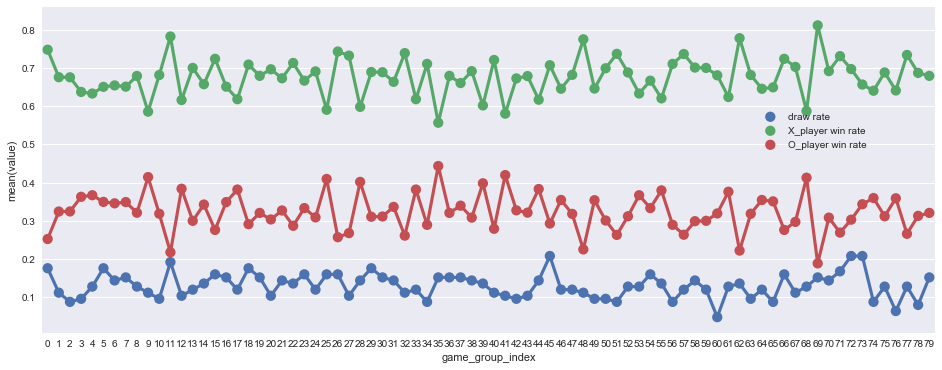

In [15]:
# This is Exerscise 0: just testing how the game goes for random action choice:
def policy_fun_rand(state, next_states, state_to_value_dict, learning_opts):
    opt_index = np.asarray([i for i in range(len(next_states))])
    action = next_states[np.random.choice(opt_index, 1)[0]]
    return action

# Learn nothing
def learn_fun_nth(state_to_value_dict, learning_opts, reward_opts, old_state, new_state, player_game_state):
    return state_to_value_dict

# Standart reward opts
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0
    }

# Create two players how randomly choose actions
player_X = player(policy_fun = policy_fun_rand, 
                  learning_fun = learn_fun_nth,
                  start_state_to_value_dict = {}, 
                  learning_opts = {})
player_O = player(policy_fun = policy_fun_rand,
                  learning_fun = learn_fun_nth,
                  start_state_to_value_dict = {},
                  learning_opts = {})
player_dict = {
    "X": player_X,
    "O": player_O
}

# Run random 10000 games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100)

# Calculate overall statistics

game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.55))

rand_X_rand_O_sns_df = copy.deepcopy(sns_df)

In [18]:
# For furthr exersices - we shall need learning function, and non-random policy functions. Let's use those:
def learn_fun_seq(state_to_value_dict, learning_opts, reward_opts, old_state, new_state, player_game_state):
    
    # If state_to_value_dicts do not exist, add the first one as random, than go on as usual
    old_state_key = old_state.tostring()
    new_state_key = new_state.tostring()
    if len(state_to_value_dict) == 0:
        state_to_value_dict[old_state_key] = [old_state, learning_opts["unknown_play_state_to_value_dict"]]
        
    oldStateIsKnown = old_state_key in state_to_value_dict
    #print("oldStateIsKnown: ", oldStateIsKnown)
    if oldStateIsKnown == False:
        state_to_value_dict[old_state_key] = [old_state, learning_opts["unknown_play_state_to_value_dict"]]
    
    newStateIsKnown = new_state_key in state_to_value_dict
    #print("newStateIsKnown: ", newStateIsKnown)
    if newStateIsKnown:
            temporal_diff = state_to_value_dict[new_state_key][1] - state_to_value_dict[old_state_key][1]        
    else:
        #print("player_game_state_2: " + player_game_state)
        if player_game_state == "Win":
            new_state_state_to_value_dict = reward_opts["win_value"]
        if player_game_state == "Loss":
            new_state_state_to_value_dict = reward_opts["loss_value"]
        if player_game_state == "Draw":
            new_state_state_to_value_dict = reward_opts["draw_value"]
        if player_game_state == "Play":
            new_state_state_to_value_dict = learning_opts["unknown_play_state_to_value_dict"]
        # This regulates whether unknown new states affect old states
        if (learning_opts["learn_from_unknown"] == True):
            temporal_diff = new_state_state_to_value_dict - state_to_value_dict[old_state_key][1]
        else:
            temporal_diff = 0
        #print("writing state_to_value_dict for state")
        #print([player_game_state, new_state_state_to_value_dict, new_state])
        state_to_value_dict[new_state_key] = [new_state, new_state_state_to_value_dict]
    
    state_to_value_dict[old_state_key][1] = state_to_value_dict[old_state_key][1] + learning_opts["step_size"] * temporal_diff
    return state_to_value_dict


# Non-random policy function
def policy_fun_greedy_rand(learning_opts, state, next_states, state_to_value_dict):
    
    next_states_value = []
    for next_state in next_states:
        stateIsKnown = next_state.tostring() in state_to_value_dict
        if stateIsKnown == False:
            next_states_value.append(learning_opts["unknown_play_state_to_value_dict"])
        else:
            state_state_to_value_dict = state_to_value_dict[next_state.tostring()][1]
            next_states_value.append(state_state_to_value_dict)
            
    
    best_indexes = np.argwhere(np.asarray(next_states_value) == np.asarray(next_states_value).max()).flatten()
    if np.random.uniform() <= learning_opts["exploring_prob"] and len(next_states) > 1:
        action = next_states[np.random.choice([i for i in range(len(next_states)) if i in best_indexes], 1)[0]]
    else:
        if len(best_indexes) > 1:
            best_index = np.random.choice(best_indexes)
        else:
            best_index = best_indexes[0]
        action = next_states[best_index]

    return action


In [44]:
# Exerscie 0.5: learning player vs random player. for this iteration - we assume that "O" is playing non-randomly, 
# "X" is playing randomly

# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0
    }

# Create learning options (it makes sense only for one though)
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_rand, 
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts
)

# O is playing greedy random
player_O = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {}, 
    learning_opts = learning_opts
)

# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}

N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.55))

rand_X_seq_O_sns_df = copy.deepcopy(sns_df)

Playing game 300 of 10000


KeyboardInterrupt: 

Playing game 9900 of 10000


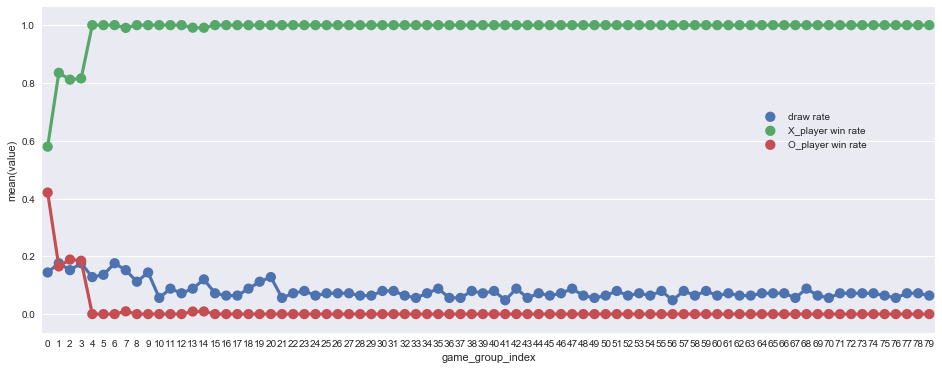

In [20]:
# Exerscie 1.1: Both players are playing non-randomly. Given that 0 player has no value for draw, and X player
# can always lead to draw, X should do better.
# If draw is the same is loss, expected behavior of draw rate is harder to predict
# In terms of policy choice - the policy will definitely be different, especially for several early "key" positions of the enemy - 
# the ones that while being far from "full" game, are still likely to be won by whoever managed to get into them.

# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0
    }

# Create learning options (it makes sense only for one though)
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts
)

# O is playing greedy random
player_O = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts
)

# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.55))

seq_X_seq_O_sns_df = copy.deepcopy(sns_df)

Playing game 9900 of 10000


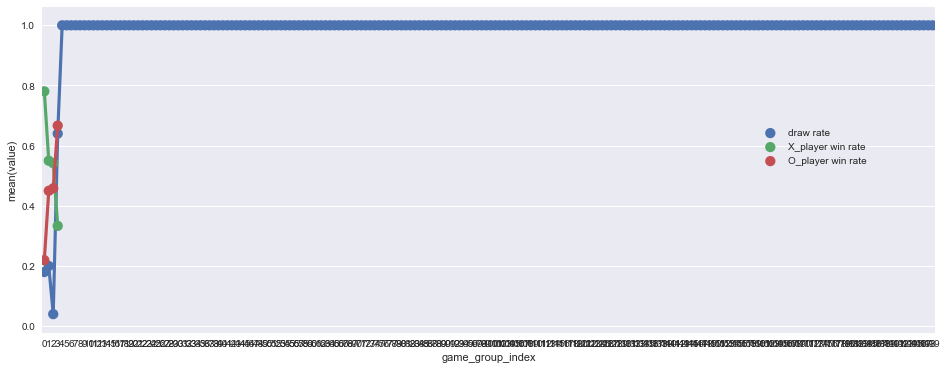

In [27]:
# Exerscie 1.1: Continuation, now let's make draw valuable

# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0.5
    }

# Create learning options (it makes sense only for one though)
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand, 
    learning_fun = learn_fun_seq, 
    start_state_to_value_dict = {},
    learning_opts = learning_opts
)

# O is playing greedy random
player_O = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts
)

# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games

# Run the games
game_stat = game_seq_stat(game_hist, 100)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.5))

seq_X_seq_O_drawHasValue_sns_df = copy.deepcopy(sns_df)

In [32]:
# Exercise 1.2 Symmetries: 
# The change is easy - we modify algorithms to consider symmetrical states as the same state
# If states are truly symmetrical (from viewpoints of BOTH players!), this should speed up the learning process
# If opponent is playing non-symmetrically (randomly or just dumb greedy) "real" value of different symmetrical states
# is different, due to opponent's reaction. So no, sorry :)
# This attempt: players are random-greedy, both symmetrical
# Also draw value is zero again)
def generate_symmetric_matrixes(m):
    ans = []
    ans.append(np.flip(m, 0))
    ans.append(np.flip(m, 1))
    ans.append(m.transpose())
    ans.append(np.flip(m.transpose(), 0))
    ans.append(np.flip(m.transpose(), 1))
    
    return ans


def learn_fun_seq_with_symm(state_to_value_dict, learning_opts, reward_opts, old_state, new_state, player_game_state):
    
    # If state_to_value_dicts do not exist, add the first one as random, than go on as usual
    old_state_key = old_state.tostring()
    new_state_key = new_state.tostring()
    
    old_state_options = [old_state] + generate_symmetric_matrixes(old_state)
    new_state_options = [new_state] + generate_symmetric_matrixes(new_state)
    
    if len(state_to_value_dict) == 0:
        state_to_value_dict[old_state_key] = [old_state, learning_opts["unknown_play_state_to_value_dict"]]
        
    oldStateIsKnown = any([x.tostring() in state_to_value_dict for x in old_state_options])
    #print("oldStateIsKnown: ", oldStateIsKnown)
    if oldStateIsKnown == False:
        state_to_value_dict[old_state_key] = [old_state, learning_opts["unknown_play_state_to_value_dict"]]
        original_old_state_key = old_state_key
    else:
        original_old_state_key = [x.tostring() for x in old_state_options if x.tostring() in state_to_value_dict][0]
    
    newStateIsKnown = any([x.tostring() in state_to_value_dict for x in new_state_options])
    #print("newStateIsKnown: ", newStateIsKnown)
    if newStateIsKnown:
        original_new_state_key = [x.tostring() for x in new_state_options if x.tostring() in state_to_value_dict][0]
        temporal_diff = state_to_value_dict[original_new_state_key][1] - state_to_value_dict[original_old_state_key][1]        
    else:
        #print("player_game_state_2: " + player_game_state)
        if player_game_state == "Win":
            new_state_state_to_value_dict = reward_opts["win_value"]
        if player_game_state == "Loss":
            new_state_state_to_value_dict = reward_opts["loss_value"]
        if player_game_state == "Draw":
            new_state_state_to_value_dict = reward_opts["draw_value"]
        if player_game_state == "Play":
            new_state_state_to_value_dict = learning_opts["unknown_play_state_to_value_dict"]
        # This regulates whether unknown new states affect old states
        if (learning_opts["learn_from_unknown"] == True):
            temporal_diff = new_state_state_to_value_dict - state_to_value_dict[original_old_state_key][1]
        else:
            temporal_diff = 0
        #print("writing state_to_value_dict for state")
        #print([player_game_state, new_state_state_to_value_dict, new_state])
        state_to_value_dict[new_state_key] = [new_state, new_state_state_to_value_dict]
    
    state_to_value_dict[original_old_state_key][1] = state_to_value_dict[original_old_state_key][1] + learning_opts["step_size"] * temporal_diff
    return state_to_value_dict


# Non-random policy function
def policy_fun_greedy_rand_with_symm(learning_opts, state, next_states, state_to_value_dict):
    
    next_states_value = []
    
    for next_state in next_states:
        next_state_options = [next_state] + generate_symmetric_matrixes(next_state)
        stateIsKnown = any([x.tostring() in state_to_value_dict for x in next_state_options])
        if stateIsKnown == False:
            next_states_value.append(learning_opts["unknown_play_state_to_value_dict"])
        else:
            next_state_key = [x.tostring() for x in next_state_options if x.tostring() in state_to_value_dict][0]
            state_state_to_value_dict = state_to_value_dict[next_state_key][1]
            next_states_value.append(state_state_to_value_dict)
            
    best_indexes = np.argwhere(np.asarray(next_states_value) == np.asarray(next_states_value).max()).flatten()
    if np.random.uniform() <= learning_opts["exploring_prob"] and len(next_states) > 1:
        action = next_states[np.random.choice([i for i in range(len(next_states)) if i in best_indexes], 1)[0]]
    else:
        if len(best_indexes) > 1:
            best_index = np.random.choice(best_indexes)
        else:
            best_index = best_indexes[0]
        action = next_states[best_index]


    return action

Playing game 9900 of 10000


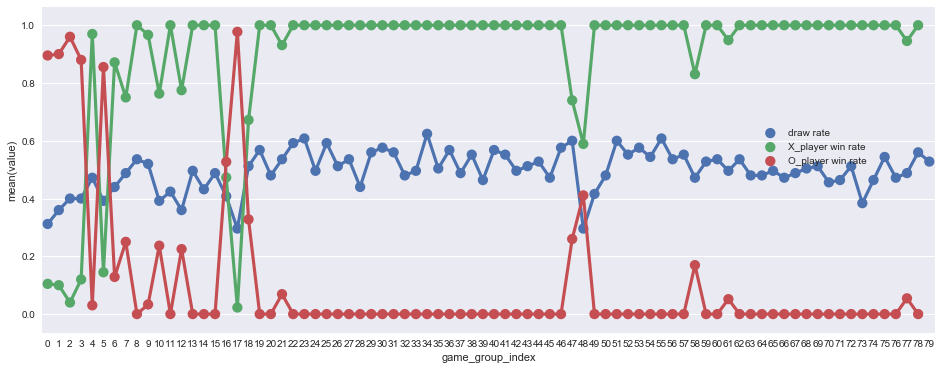

In [33]:
# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0
    }

# Create learning options (it makes sense only for one though)
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand_with_symm,
    learning_fun = learn_fun_seq_with_symm, 
    start_state_to_value_dict = {}, 
    learning_opts = learning_opts
)

# O is playing greedy random
player_X = player(
    policy_fun = policy_fun_greedy_rand_with_symm,
    learning_fun = learn_fun_seq_with_symm, 
    start_state_to_value_dict = {}, 
    learning_opts = learning_opts
)


# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.5))

symmSeq_X_symmSeq_O_sns_df = copy.deepcopy(sns_df)

Playing game 19900 of 20000


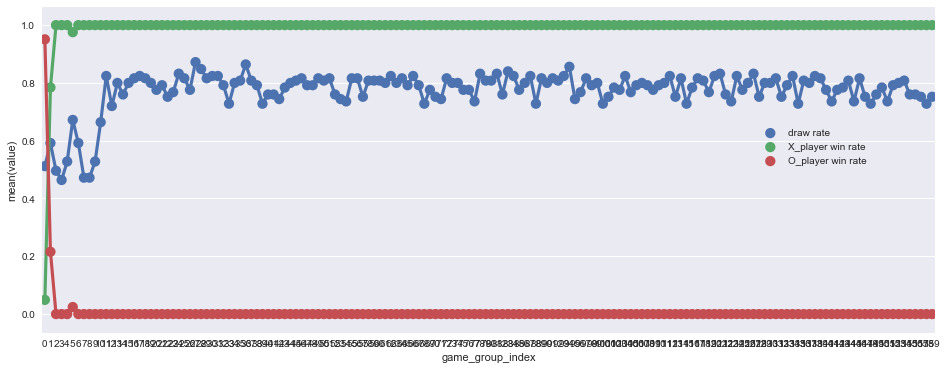

In [34]:
# Exercise 1.2 Symmetries, continuation
# The change is easy - we modify algorithms to consider symmetrical states as the same state
# If states are truly symmetrical (from viewpoints of BOTH players!), this should speed up the learning process
# If opponent is playing non-symmetrically (randomly or just dumb greedy) "real" value of different symmetrical states
# is different, due to opponent's reaction. So no, sorry :)
# This attempt: players are random-greedy, both symmetrical
# Also draw value is 0.5

# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0.5
    }

# Create learning options (it makes sense only for one though)
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand_with_symm,
    learning_fun = learn_fun_seq_with_symm, 
    start_state_to_value_dict = {}, 
    learning_opts = learning_opts
)

# O is playing greedy random
player_X = player(
    policy_fun = policy_fun_greedy_rand_with_symm,
    learning_fun = learn_fun_seq_with_symm, 
    start_state_to_value_dict = {}, 
    learning_opts = learning_opts
)


# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games

# Run the games
N_games = 20000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.5))

symmSeq_X_symmSeq_O_drawHasValue_sns_df = copy.deepcopy(sns_df)

Playing game 9900 of 10000


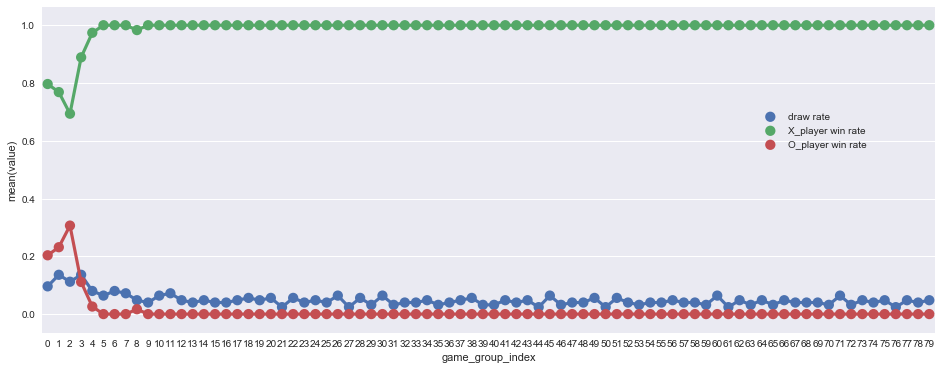

In [35]:
# Exercise 1.3: Greedy play.
# We shall set "exploration" probability to zero for one player, and leave it normal for another player
# For "equal" options the choice is random
# The expectation is that non-exploring player will fall into a pattern that will be dominated by exploring player
# However: for "non-exploring" player, the "exploring" player still plays the role of exploration, just not a deliberate one

# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0
    }

# Create learning options
# Non-exploring
learning_opts_X = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.0
    }

learning_opts_O = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }


# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts_X
)

# O is playing greedy random
player_O = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts_O
)

# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.55))

seq_X_seq_O_sns_df = copy.deepcopy(sns_df)

NonExploreSeq_X_ExploreSeq_O_sns_df = copy.deepcopy(sns_df)

Playing game 9900 of 10000


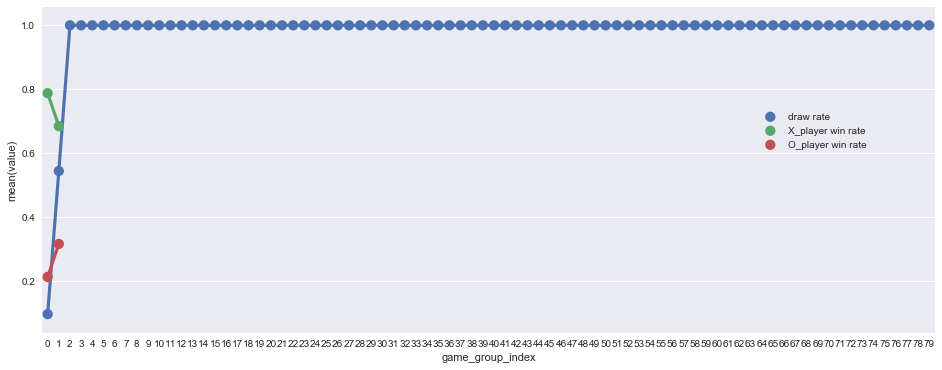

In [36]:
# Exercise 1.3: Greedy play.
# We shall set "exploration" probability to zero for one player, and leave it normal for another player
# For "equal" options the choice is random
# The expectation is that non-exploring player will fall into a pattern that will be dominated by exploring player
# Now with draw positive value - draw is always an option (as we know ourselves), and we expect O to be able to catch
# into the draw trajectory.


# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0.5
    }

# Create learning options
# Non-exploring
learning_opts_X = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.0
    }

learning_opts_O = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }


# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts_X
)

# O is playing greedy random
player_O = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts_O
)

# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.55))

seq_X_seq_O_sns_df = copy.deepcopy(sns_df)

NonExploreSeq_X_ExploreSeq_O_drawHasValue_sns_df = copy.deepcopy(sns_df)

In [45]:
def learn_fun_step_decrease_seq(state_to_value_dict, learning_opts, reward_opts, old_state, new_state, player_game_state):
    
    # If state_to_value_dicts do not exist, add the first one as random, than go on as usual
    old_state_key = old_state.tostring()
    new_state_key = new_state.tostring()
    if len(state_to_value_dict) == 0:
        state_to_value_dict[old_state_key] = [old_state, learning_opts["unknown_play_state_to_value_dict"]]
        
    oldStateIsKnown = old_state_key in state_to_value_dict
    #print("oldStateIsKnown: ", oldStateIsKnown)
    if oldStateIsKnown == False:
        state_to_value_dict[old_state_key] = [old_state, learning_opts["unknown_play_state_to_value_dict"]]
    
    newStateIsKnown = new_state_key in state_to_value_dict
    #print("newStateIsKnown: ", newStateIsKnown)
    if newStateIsKnown:
            temporal_diff = state_to_value_dict[new_state_key][1] - state_to_value_dict[old_state_key][1]        
    else:
        #print("player_game_state_2: " + player_game_state)
        if player_game_state == "Win":
            new_state_state_to_value_dict = reward_opts["win_value"]
        if player_game_state == "Loss":
            new_state_state_to_value_dict = reward_opts["loss_value"]
        if player_game_state == "Draw":
            new_state_state_to_value_dict = reward_opts["draw_value"]
        if player_game_state == "Play":
            new_state_state_to_value_dict = learning_opts["unknown_play_state_to_value_dict"]
        # This regulates whether unknown new states affect old states
        if (learning_opts["learn_from_unknown"] == True):
            temporal_diff = new_state_state_to_value_dict - state_to_value_dict[old_state_key][1]
        else:
            temporal_diff = 0
        #print("writing state_to_value_dict for state")
        #print([player_game_state, new_state_state_to_value_dict, new_state])
        state_to_value_dict[new_state_key] = [new_state, new_state_state_to_value_dict]
    # Add step-size decrease to the function (not pretty, but works)
    learning_opts["step_size"] = max(0.0, learning_opts["step_size"] - learning_opts["step_size_decrease"])
    state_to_value_dict[old_state_key][1] = state_to_value_dict[old_state_key][1] + learning_opts["step_size"] * temporal_diff
    return state_to_value_dict

Playing game 9900 of 10000


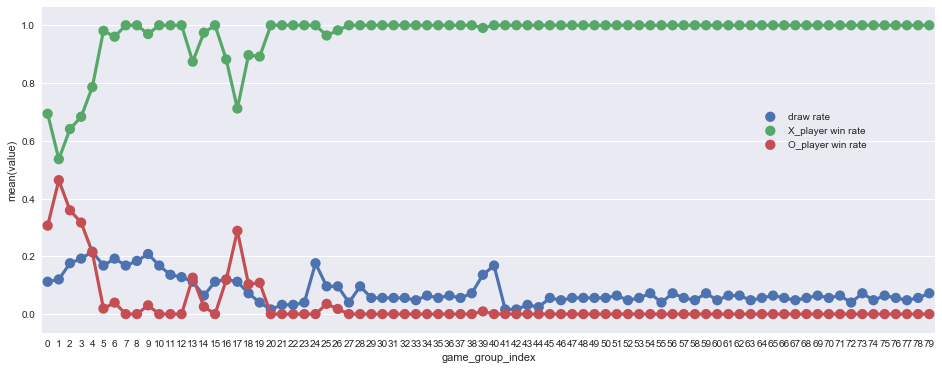

In [60]:
# Exercise 1.4: Learnig from exploration.
# What learning from "exploration" moves does is makes the player less "sure" about the state value
# estimation for longer periods of time. As long as there are "unknown" states to follow after other states
# the player will keep that state's estimation closer to "unknown".

# Now, we need to add step-reducing process.

# Create reward options
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0
    }

# Create learning options
# Non-exploring
learning_opts_X = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "step_size_decrease": 0.0,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

learning_opts_O = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.2,
    "step_size_decrease": 0.0,
    "learn_from_unknown": False,
    "exploring_prob": 0.1
    }

# Decreasing step (notice that )


# Create players
#X is playing randomly (though learning)
player_X = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_step_decrease_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts_X
)

# O is playing greedy random
player_O = player(
    policy_fun = policy_fun_greedy_rand,
    learning_fun = learn_fun_step_decrease_seq,
    start_state_to_value_dict = {},
    learning_opts = learning_opts_O
)

# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}


# Run the games
N_games = 10000

game_hist = run_n_games(
    player_dict=player_dict,
    reward_opts = reward_opts,
    N_games = N_games,
    print_every_n = 100
)

# Run the games
game_stat = game_seq_stat(game_hist, 250)
sns_df = create_sns_df(game_stat)
fig, ax = plt.subplots(figsize=(16, 6))
sns.pointplot(
    x = sns_df["game_group_index"], 
    y = sns_df["value"],
    hue = sns_df["variable"]
)
ax.legend(loc = (0.8, 0.55))

seq_X_stepSizeDecreaseExplore_O_drawHasValue_sns_df = copy.deepcopy(sns_df)

In [ ]:
########## ALL STUFF AFTER THIS IS WIP ##########

In [ ]:
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0.5
    }
    
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.3,
    "learn_from_unknown": False
    }

player_X = player(
    policy_fun = policy_fun_rand, learning_fun = learn_fun_seq, start_state_to_value_dict = [], learning_opts = learning_opts
)
player_O = player(
    policy_fun = policy_fun_rand, learning_fun = learn_fun_seq, start_state_to_value_dict = [], learning_opts = learning_opts
)
# Take players
player_dict = {
    "X": player_X,
    "O": player_O
}

# Start the game
N_games = 1000
game_hist = []
prev_len = 0
counter = 0 
for j in range(N_games):
    
    if j % 50 == 0:
        print(j)
        
    tic_tac_toe = game(
        start_state = start_state, 
        action_state_fun = action_state_fun,
        next_game_step_fun = next_game_step_fun,
        is_end_fun = is_end_fun,
        game_status_fun = game_status,
        reward_opts = reward_opts
        )
    
    game_is_done = False #Different from just last state - we have to teach players once we are done
    # Allows to stop the game properly
    player_status_dict = {
        "X": "Play",
        "O": "Play"
    }
    prev_players_state_dict = {"X": start_state, "Y": start_state}
    counter = 0 #Here do identify step and used for determining start
    while game_is_done == False:
        
        # This determines whether all players have "learned" after the game finished
        game_is_done = any([player_status_dict[x] == "Play" for x in player_status_dict]) == False
        
        step_next_states, step_player_name = tic_tac_toe.next_states()
        step_player = player_dict[step_player_name]
        # Remember state before opponent made a move (we think of him as "nature")
        observer_player_name = [x for x in player_dict.keys() if x != step_player_name][0]
        prev_players_state_dict[observer_player_name] = tic_tac_toe.state 
        
        #Make a step in the game:
        if (tic_tac_toe.game_status()[0] == "Play"):
            tic_tac_toe.step(player = step_player, next_states = step_next_states)  
        
        # No backprop for first step
        if counter == 0:
            counter = counter + 1
            game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
            next
        
        # Otherwise make a backprop
        
        if tic_tac_toe.game_status()[0] == "Play":
            player_game_state = "Play"
        else:
            if tic_tac_toe.game_status()[0] == "Draw":
                player_game_state = "Draw"
            else:
                if tic_tac_toe.game_status()[0] == "Win" and tic_tac_toe.game_status()[1] == step_player_name:
                    player_game_state = "Win"
                else:
                    player_game_state = "Loss"
        player_status_dict[step_player_name] = player_game_state
            
        #Teach player backprop after his step
        player_dict[step_player_name].learn(
            reward_opts = tic_tac_toe.reward_opts,
            old_state = prev_players_state_dict[step_player_name],
            new_state = tic_tac_toe.state,
            player_game_state = player_game_state
        )
        counter = counter + 1
        
    # Write game history
    game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
    





In [ ]:
#STOPHERE, TEST THIS
N_games = 1000
game_hist = []
prev_len = 0
counter = 0 

for j in range(N_games):
    
    if j % 10 == 0:
        print(j)
        
    tic_tac_toe = game(
        start_state = start_state, 
        action_state_fun = action_state_fun,
        next_game_step_fun = next_game_step_fun,
        is_end_fun = is_end_fun,
        game_status_fun = game_status,
        reward_opts = reward_opts
        )
    
    game_is_done = False #Different from just last state - we have to teach players once we are done
    # Allows to stop the game properly
    player_status_dict = {
        "X": "Play",
        "O": "Play"
    }
    prev_players_state_dict = {"X": start_state, "Y": start_state}
    counter = 0 #Here do identify step and used for determining start
    while game_is_done == False:
        
        game_is_done = any([player_status_dict[x] == "Play" for x in player_status_dict]) == False
        
        step_next_states, step_player_name = tic_tac_toe.next_states()
        #print(step_next_states)
        step_player = player_dict[step_player_name]
        #print("Player " + step_player_name + " is playing")
        # Remember state before opponent made a move (we think of him as "nature")
        observer_player_name = [x for x in player_dict.keys() if x != step_player_name][0]
        #print("Player " + observer_player_name + " is observing")
        prev_players_state_dict[observer_player_name] = tic_tac_toe.state 
        
        #Make a step in the game:
        #print("Game status: " + tic_tac_toe.game_status()[0])
        if (tic_tac_toe.game_status()[0] == "Play"):
            tic_tac_toe.step(player = step_player, next_states = step_next_states)  
        
        # No backprop for first step
        if counter == 0:
            counter = counter + 1
            #print(counter)
            game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
            next
        
        # Otherwise make a backprop
        if tic_tac_toe.game_status()[0] == "Play":
            player_game_state = "Play"
        else:
            if tic_tac_toe.game_status()[0] == "Draw":
                player_game_state = "Draw"
            else:
                if tic_tac_toe.game_status()[0] == "Win" and tic_tac_toe.game_status()[1] == step_player_name:
                    player_game_state = "Win"
                else:
                    player_game_state = "Loss"
        player_status_dict[step_player_name] = player_game_state
        #print("Player game state: " + player_game_state)
        #print(tic_tac_toe.state)
            
            
        #print("Player " + step_player_name + " is learning")
        #print("Old state:")
        #print(prev_players_state_dict[step_player_name])
        #print("New state:")
        #print(tic_tac_toe.state)
        player_dict[step_player_name].learn(
            reward_opts = tic_tac_toe.reward_opts,
            old_state = prev_players_state_dict[step_player_name],
            new_state = tic_tac_toe.state,
            player_game_state = player_game_state
        )
        counter = counter + 1
        #print(counter)
        
        
    game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
    


In [ ]:
game_states = np.unique(np.asarray([x[0][0] for x in game_hist]), return_counts = True)
win_counts = np.unique(np.asarray([x[0][1] for x in game_hist if x[0][0] == "Win"]), return_counts = True)
print(
    {k: v for k,v in zip(game_states[0], game_states[1])},
    {k: v for k,v in zip(win_counts[0], win_counts[1])}
    )

In [ ]:
# let's see how expected state_to_value_dict is distributed at each game step for one player
state_distr_arr_X = [
    {"n_empty_cells": np.apply_along_axis(lambda x: sum(x == ""), 0 , s.flatten()).take(0),
    "expected_win_prob": v} \
    for [s,v] in player_dict["X"].state_to_value_dict
]
state_distr_arr_O = [
    {"n_empty_cells": np.apply_along_axis(lambda x: sum(x == ""), 0 , s.flatten()).take(0),
    "expected_win_prob": v} \
    for [s,v] in player_dict["O"].state_to_value_dict
]


In [ ]:
state_distr_X_df = pd.DataFrame(state_distr_arr_X)
state_distr_O_df = pd.DataFrame(state_distr_arr_O)
# Saving for final comparison
double_random_distr_X_df = state_distr_X_df
double_random_distr_O_df = state_distr_O_df

In [ ]:
%matplotlib inline
g = sns.FacetGrid(state_distr_X_df, row="n_empty_cells")
g = g.map(plt.hist, "expected_win_prob")
#sns.distplot(state_distr_X_df[["expected_win_prob"], )

In [ ]:
# This one seems legit
# Next stop - non-random search

In [ ]:
def policy_fun_greedy_rand(learning_opts, state, next_states, state_to_value_dict):
    
    next_states_value = []
    for next_state in next_states:
        stateIsKnown = any([np.array_equal(next_state, x[0]) for x in state_to_value_dict])
        
        if stateIsKnown == False:
            next_states_value.append(learning_opts["unknown_play_state_to_value_dict"])
        else:
            state_index = [np.array_equal(next_state, x[0]) for x in state_to_value_dict].index(True)
            state_state_to_value_dict = state_to_value_dict[state_index][1]
            next_states_value.append(state_state_to_value_dict)
            
    if np.random.uniform() <= learning_opts["exploring_prob"]:
        opt_index = np.asarray([i for i in range(len(next_states))])
        action = next_states[np.random.choice(opt_index, 1)[0]]
    else:
        best_index = np.asarray(next_states_value).argmax(0)
        action = next_states[best_index]

    return action

In [ ]:
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0.5
    }
    
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.3,
    "exploring_prob": 0.4,
    "learn_from_unknown": False
    }

player_X = player(
    policy_fun = policy_fun_greedy_rand, learning_fun = learn_fun_seq, start_state_to_value_dict = [], learning_opts = learning_opts
)
player_O = player(
    policy_fun = policy_fun_greedy_rand, learning_fun = learn_fun_seq, start_state_to_value_dict = [], learning_opts = learning_opts
)

player_dict = {
    "X": player_X,
    "O": player_O
}

In [ ]:
N_games = 1000
game_hist = []
prev_len = 0
counter = 0 

for j in range(N_games):
    
    if j % 50 == 0:
        print(j)
        
    tic_tac_toe = game(
        start_state = start_state, 
        action_state_fun = action_state_fun,
        next_game_step_fun = next_game_step_fun,
        is_end_fun = is_end_fun,
        game_status_fun = game_status,
        reward_opts = reward_opts
        )
    
    game_is_done = False #Different from just last state - we have to teach players once we are done
    # Allows to stop the game properly
    player_status_dict = {
        "X": "Play",
        "O": "Play"
    }
    prev_players_state_dict = {"X": start_state, "Y": start_state}
    counter = 0 #Here do identify step and used for determining start
    while game_is_done == False:
        
        game_is_done = any([player_status_dict[x] == "Play" for x in player_status_dict]) == False
        
        step_next_states, step_player_name = tic_tac_toe.next_states()
        #print(step_next_states)
        step_player = player_dict[step_player_name]
        #print("Player " + step_player_name + " is playing")
        # Remember state before opponent made a move (we think of him as "nature")
        observer_player_name = [x for x in player_dict.keys() if x != step_player_name][0]
        #print("Player " + observer_player_name + " is observing")
        prev_players_state_dict[observer_player_name] = tic_tac_toe.state 
        
        #Make a step in the game:
        #print("Game status: " + tic_tac_toe.game_status()[0])
        if (tic_tac_toe.game_status()[0] == "Play"):
            tic_tac_toe.step(player = step_player, next_states = step_next_states)  
        
        # No backprop for first step
        if counter == 0:
            counter = counter + 1
            #print(counter)
            game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
            next
        
        # Otherwise make a backprop
        if tic_tac_toe.game_status()[0] == "Play":
            player_game_state = "Play"
        else:
            if tic_tac_toe.game_status()[0] == "Draw":
                player_game_state = "Draw"
            else:
                if tic_tac_toe.game_status()[0] == "Win" and tic_tac_toe.game_status()[1] == step_player_name:
                    player_game_state = "Win"
                else:
                    player_game_state = "Loss"
        player_status_dict[step_player_name] = player_game_state
        #print("Player game state: " + player_game_state)
        #print(tic_tac_toe.state)
            
            
        #print("Player " + step_player_name + " is learning")
        #print("Old state:")
        #print(prev_players_state_dict[step_player_name])
        #print("New state:")
        #print(tic_tac_toe.state)
        player_dict[step_player_name].learn(
            reward_opts = tic_tac_toe.reward_opts,
            old_state = prev_players_state_dict[step_player_name],
            new_state = tic_tac_toe.state,
            player_game_state = player_game_state
        )
        counter = counter + 1
        #print(counter)
        
        
    game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))

In [ ]:
game_states = np.unique(np.asarray([x[0][0] for x in game_hist]), return_counts = True)
win_counts = np.unique(np.asarray([x[0][1] for x in game_hist if x[0][0] == "Win"]), return_counts = True)

In [ ]:
print(
    {k: v for k,v in zip(game_states[0], game_states[1])},
    {k: v for k,v in zip(win_counts[0], win_counts[1])}
    )

In [ ]:
state_distr_arr_X = [
    {"n_empty_cells": np.apply_along_axis(lambda x: sum(x == ""), 0 , s.flatten()).take(0),
    "expected_win_prob": v} \
    for [s,v] in player_dict["X"].state_to_value_dict
]
state_distr_arr_O = [
    {"n_empty_cells": np.apply_along_axis(lambda x: sum(x == ""), 0 , s.flatten()).take(0),
    "expected_win_prob": v} \
    for [s,v] in player_dict["O"].state_to_value_dict
]

In [ ]:
state_distr_X_df = pd.DataFrame(state_distr_arr_X)
state_distr_O_df = pd.DataFrame(state_distr_arr_O)
# Saving for final comparison
double_randomGreed_distr_X_df = state_distr_X_df
double_randomGreed_distr_O_df = state_distr_O_df

In [ ]:
%matplotlib inline
g = sns.FacetGrid(state_distr_X_df, row="n_empty_cells")
g = g.map(plt.hist, "expected_win_prob")
#sns.distplot(state_distr_X_df[["expected_win_prob"], )

In [ ]:
reward_opts = {
    "win_value": 1,
    "loss_value": 0,
    "draw_value": 0.5
    }
    
learning_opts = {    
    "unknown_play_state_to_value_dict": 0.5,
    "step_size": 0.3,
    "exploring_prob": 0.4
    }

player_X = player(
    policy_fun = policy_fun_rand, learning_fun = learn_fun_seq, start_state_to_value_dict = [], learning_opts = learning_opts
)
player_O = player(
    policy_fun = policy_fun_greedy_rand, learning_fun = learn_fun_seq, start_state_to_value_dict = [], learning_opts = learning_opts
)

player_dict = {
    "X": player_X,
    "O": player_O
}

In [ ]:
N_games = 1000
game_hist = []
prev_len = 0
counter = 0 

for j in range(N_games):
    
    if j % 50 == 0:
        print(j)
        
    tic_tac_toe = game(
        start_state = start_state, 
        action_state_fun = action_state_fun,
        next_game_step_fun = next_game_step_fun,
        is_end_fun = is_end_fun,
        game_status_fun = game_status,
        reward_opts = reward_opts
        )
    
    game_is_done = False #Different from just last state - we have to teach players once we are done
    # Allows to stop the game properly
    player_status_dict = {
        "X": "Play",
        "O": "Play"
    }
    prev_players_state_dict = {"X": start_state, "Y": start_state}
    counter = 0 #Here do identify step and used for determining start
    while game_is_done == False:
        
        game_is_done = any([player_status_dict[x] == "Play" for x in player_status_dict]) == False
        
        step_next_states, step_player_name = tic_tac_toe.next_states()
        #print(step_next_states)
        step_player = player_dict[step_player_name]
        #print("Player " + step_player_name + " is playing")
        # Remember state before opponent made a move (we think of him as "nature")
        observer_player_name = [x for x in player_dict.keys() if x != step_player_name][0]
        #print("Player " + observer_player_name + " is observing")
        prev_players_state_dict[observer_player_name] = tic_tac_toe.state 
        
        #Make a step in the game:
        #print("Game status: " + tic_tac_toe.game_status()[0])
        if (tic_tac_toe.game_status()[0] == "Play"):
            tic_tac_toe.step(player = step_player, next_states = step_next_states)  
        
        # No backprop for first step
        if counter == 0:
            counter = counter + 1
            #print(counter)
            game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))
            next
        
        # Otherwise make a backprop
        if tic_tac_toe.game_status()[0] == "Play":
            player_game_state = "Play"
        else:
            if tic_tac_toe.game_status()[0] == "Draw":
                player_game_state = "Draw"
            else:
                if tic_tac_toe.game_status()[0] == "Win" and tic_tac_toe.game_status()[1] == step_player_name:
                    player_game_state = "Win"
                else:
                    player_game_state = "Loss"
        player_status_dict[step_player_name] = player_game_state
        #print("Player game state: " + player_game_state)
        #print(tic_tac_toe.state)
            
            
        #print("Player " + step_player_name + " is learning")
        #print("Old state:")
        #print(prev_players_state_dict[step_player_name])
        #print("New state:")
        #print(tic_tac_toe.state)
        player_dict[step_player_name].learn(
            reward_opts = tic_tac_toe.reward_opts,
            old_state = prev_players_state_dict[step_player_name],
            new_state = tic_tac_toe.state,
            player_game_state = player_game_state
        )
        counter = counter + 1
        #print(counter)
        
        
    game_hist.append((tic_tac_toe.game_status(), tic_tac_toe.state, tic_tac_toe.is_end()))

In [ ]:
game_states = np.unique(np.asarray([x[0][0] for x in game_hist]), return_counts = True)
win_counts = np.unique(np.asarray([x[0][1] for x in game_hist if x[0][0] == "Win"]), return_counts = True)

In [ ]:
print(
    {k: v for k,v in zip(game_states[0], game_states[1])},
    {k: v for k,v in zip(win_counts[0], win_counts[1])}
    )

In [ ]:
# Well, at least this works
state_distr_arr_X = [
    {"n_empty_cells": np.apply_along_axis(lambda x: sum(x == ""), 0 , s.flatten()).take(0),
    "expected_win_prob": v} \
    for [s,v] in player_dict["O"].state_to_value_dict
]
state_distr_arr_O = [
    {"n_empty_cells": np.apply_along_axis(lambda x: sum(x == ""), 0 , s.flatten()).take(0),
    "expected_win_prob": v} \
    for [s,v] in player_dict["O"].state_to_value_dict
]
state_distr_X_df = pd.DataFrame(state_distr_arr_X)
state_distr_O_df = pd.DataFrame(state_distr_arr_O)
# Saving for final comparison
Xrandom_OrandomGreed_distr_X_df = state_distr_X_df
Xrandom_OrandomGreed_distr_O_df = state_distr_O_df

In [ ]:
%matplotlib inline
g = sns.FacetGrid(state_distr_X_df, row="n_empty_cells")
g = g.map(plt.hist, "expected_win_prob")
#sns.distplot(state_distr_X_df[["expected_win_prob"], )

In [ ]:
compare_list = [
    double_random_distr_X_df.assign(strategy = "random", player = "X"),
    double_random_distr_O_df.assign(strategy = "random", player = "O"),
    double_randomGreed_distr_X_df.assign(strategy = "randomGreed", player = "X"),
    double_randomGreed_distr_O_df.assign(strategy = "randomGreed", player = "O"),
    Xrandom_OrandomGreed_distr_X_df.assign(strategy = "Xrandom_OrandomGreed", player = "X"),
    Xrandom_OrandomGreed_distr_O_df.assign(strategy = "Xrandnom_OrandomGreed", player = "O")
]

In [ ]:
compare_df = pd.concat(compare_list)

In [ ]:
%matplotlib inline
g = sns.FacetGrid(compare_df, row = ("n_empty_cells", "player"), col = "strategy")
g = g.map(plt.hist, "expected_win_prob")